In [3]:
import os
import cv2
from PIL import Image
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

In [6]:
class CamouflageDataset(Dataset):
    def __init__(self, image_dir, gt_dir, image_transform=None, gt_transform=None):
        """
        Args:
            image_dir (str): 普通图像文件夹路径。
            gt_dir (str): 掩码图像文件夹路径。
            image_transform (callable, optional): 图像的变换操作。
            gt_transform (callable, optional): 掩码的变换操作。
        """
        self.image_dir = image_dir
        self.gt_dir = gt_dir
        self.image_transform = image_transform
        self.gt_transform = gt_transform
        self.image_names = os.listdir(image_dir)  # 获取所有图像文件名

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # 加载普通图像
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")  # 确保图像是 RGB 格式

        # 加载对应的掩码图像
        gt_name = image_name.replace(".jpg", ".png")  # 假设掩码图像文件名与普通图像文件名一致，只是扩展名不同
        gt_path = os.path.join(self.gt_dir, gt_name)
        gt = Image.open(gt_path).convert("L")  # 转换为灰度图像

        # 将图像和掩码转换为 NumPy 数组
        image = np.array(image)
        gt = np.array(gt)

        # 将掩码二值化（0 表示背景，1 表示目标）
        gt = (gt > 128).astype(np.float32)

        # 应用变换（如果有）
        if self.image_transform:
            image = self.image_transform(image)
        if self.gt_transform:
            gt = self.gt_transform(gt)

        # 返回图像和掩码
        return image, gt

# 定义图像变换
image_transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为 PyTorch 张量
    transforms.Resize((300,400)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 归一化
])

# 定义掩码变换
gt_transform = transforms.Compose([
    transforms.ToTensor(),  # 将掩码转换为 PyTorch 张量
    transforms.Resize((300,400)),
    transforms.Lambda(lambda x: (x > 0.5).float())  # 将掩码二值化
])

# 定义数据集路径
train_image_dir = "datasets/dataset/train/image"
train_gt_dir = "datasets/dataset/train/GT"

# 创建数据集实例
train_dataset = CamouflageDataset(image_dir=train_image_dir, gt_dir=train_gt_dir, image_transform=image_transform, gt_transform=gt_transform)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# 定义测试数据集路径
test_image_dir = "datasets/dataset/test/image"
test_gt_dir = "datasets/dataset/test/GT"

# 创建测试数据集实例
test_dataset = CamouflageDataset(image_dir=test_image_dir, gt_dir=test_gt_dir, image_transform=image_transform, gt_transform=gt_transform)

# 创建测试 DataLoader
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


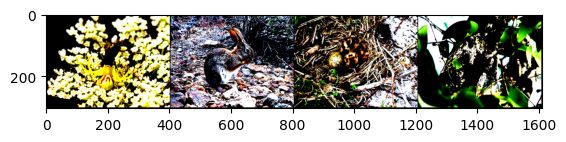

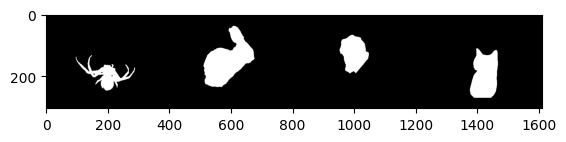

In [12]:
# show the data 
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, masks = next(dataiter)
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(masks))

In [26]:
# 特征提取
# 提取颜色直方图特征
def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# 提取LBP纹理特征
def extract_lbp_feature(image, radius=3, n_points=24):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, n_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # 归一化
    return hist

# 提取每张图像的特征
def extract_features(images, features_list):
    for image in images:
        image = image.permute(1, 2, 0).cpu().numpy()
        # 转换为OpenCV格式
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # 提取颜色直方图特征
        hist_feature = extract_color_histogram(image_bgr)
        # 提取LBP纹理特征
        lbp_feature = extract_lbp_feature(image_bgr)
        # 合并特征
        combined_feature = np.hstack([hist_feature, lbp_feature])
        features_list.append(combined_feature)
    return features_list

# 提取标签
def extract_labels(masks, labels_list):
    for mask in masks:
        label = (mask > 0).to(torch.bool).flatten().numpy()
        labels_list.append(label)
    return labels_list

In [29]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim=200, output_dim=100, hidden_dim=128):
        super(MLPClassifier, self).__init__()
        # 定义全连接层
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        # 定义激活函数
        self.relu = nn.ReLU()  
        # 定义输出层的激活函数为 sigmoid，用于输出0到1之间的值
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 第一层全连接 + 激活函数
        x = self.relu(self.fc1(x))
        # 第二层全连接 + 激活函数
        x = self.relu(self.fc2(x))
        # 第三层全连接 + sigmoid 激活函数
        x = self.sigmoid(self.fc3(x))
        return x

In [33]:
# 初始化模型
model = MLPClassifier(input_dim=538, output_dim=120000, hidden_dim=6400)
# 定义损失函数为二进制交叉熵损失 (BCELoss)
criterion = nn.BCELoss()
# 定义优化器为 Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 训练
total_epochs = 2
features_list=[]
labels_list=[]
for epoch in range(total_epochs):
    running_loss = 0.0
    for iter, (images, masks) in enumerate(train_loader, start=1):
        optimizer.zero_grad()
        features_list = extract_features(images,features_list)
        labels_list = extract_labels(masks, labels_list)
        outputs = model(torch.tensor(features_list, dtype=torch.float32))
        loss = criterion(outputs, torch.tensor(labels_list, dtype=torch.float32))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if iter % 50 == 50:
            print(f'[{epoch}, {iter}] loss: {running_loss / 50}')
            running_loss = 0.0
            
print('Finished Training')

Iteration: 1
(538,)
(538,)
(538,)
(538,)
(120000,)
(120000,)
(120000,)
(120000,)


(2900, 538)
(2900, 120000)


ValueError: Found input variables with inconsistent numbers of samples: [1, 120000]